In [1]:
include("../BayesianUtilities.jl")
using Distributions, LinearAlgebra, Plots, Random, .BayesianUtilities
using DataStructures: Queue, enqueue!, dequeue!

In [17]:
# True unknown position update matrix for the moving dynamics
Random.seed!(1)
M = [1. -0.4; 0.7 0.8]
eigen(M)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
2-element Array{Complex{Float64},1}:
 0.8999999999999999 - 0.5196152422706631im
 0.8999999999999999 + 0.5196152422706631im
vectors:
2×2 Array{Complex{Float64},2}:
 0.113961-0.592157im  0.113961+0.592157im
 0.797724-0.0im       0.797724+0.0im

In [31]:
T = 30
states = ones(2,T)
observation = ones(T)

for t=2:T
    states[:,t] = M*states[:,t-1]
    observation[t] = rand(Poisson(exp(states[1,t])))
end

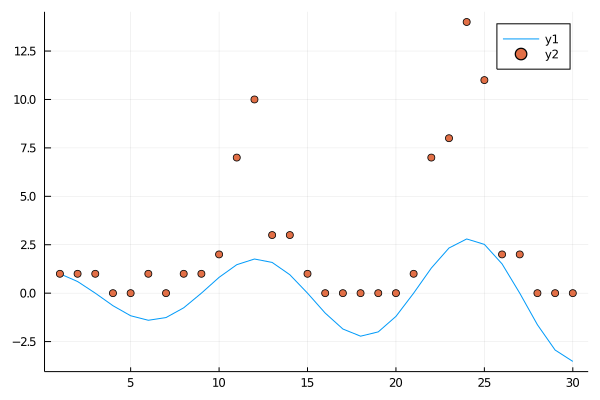

In [33]:
plot(states[1,:])
scatter!(observation)

# Model Specification

In [61]:
# Newtonian dynamics assumption
A = [1. 1.; 0. 1.]
B = [1. 0.]

# Priors
p_z_init = MvNormal(zeros(2),100*diagm(0=>ones(2)))
p_W = Wishart(2,diagm(0=>ones(2)))

# Non-conjugate loglikelihood function
function log_likelihood(y,z)
    x = exp((B*z)[1]) # B*z returns 1 dimensional array
    logpdf(Poisson(x),y)
end

log_likelihood (generic function with 2 methods)

# Inference

In [62]:
# initialize recognition factors for r and W so that q_z can be updated
q_W = p_W
;

In [63]:
# CVI message towards z
function approx_message_z(obs::Real,mes_income::MvNormal,η::Real,n_its::Int)
    q = mes_income # initialize variational distribution with closed form incoming message
    _, _, λ_q, _, _ = exp_family(q) # initial variational parameters
    λ_m = zeros(6) # initial message parameters
    optimizer = ConvexAdam(η, 6) # initialize optimizer as convex combination Adam
    violation = 0 # keep track of number of updates lead to invalid parameters 
    λ_m_latest = Queue{Vector}()
    for n=1:n_its
        logp(z) = log_likelihood(obs,z)
        grad = cvi(logp,q) # grad estimates
        λ_m_old = λ_m # to check the convergence
        λ_m = opt_step!(optimizer, λ_m, grad) # update message parameters
        λ_q = λ_q .+ λ_m # update variational parameters
        try
            q = exp_family(MvNormal, λ_q) # update q
            enqueue!(λ_m_latest, λ_m_old)
            if n>9
                λ_m_average = sum(λ for λ in λ_m_latest)./10
                if norm(λ_m.-λ_m_average) < 0.001
                    println("Converged in step ",n)
                    break
                end
                dequeue!(λ_m_latest);
            end
        catch
            λ_q = λ_q .- λ_m # avoid updates that violate the support of Gaussian
            violation += 1
            @show violation
        end
    end
    return λ_m # return approximate message parameters
end

approx_message_z (generic function with 2 methods)

In [64]:
function filter(qW, T)
    W = mean(qW)
    forward_estimates = Array{MvNormal}(undef, T)
    λ_m = approx_message_z(observation[1],p_z_init,0.4,5000)   
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m))
    for t=2:T
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))))
        λ_m = approx_message_z(observation[t],predict,0.4,5000)
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m))
    end
    return forward_estimates
end

function smooth(forward_estimates, qW, T)
    W = mean(qW)
    smooth_estimates = Array{MvNormal}(undef, T)
    smooth_estimates[T] = forward_estimates[T]
    joint_dists = Array{MvNormal}(undef, T-1)
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,W)
    end
    return smooth_estimates, joint_dists
end
;

In [67]:
n_its = 5
FE = zeros(n_its+1)
# Variational updates
for i=1:n_its
    # Update q(z_{1:T})
    forward_estimates = filter(q_W,T)
    smooth_estimates, joint_dists = smooth(forward_estimates, q_W, T)
    
    # Calculate Free Energy before q_W and q_r updates. FE_0
    if i==1
        F = -entropy(q_W) - entropy(smooth_estimates[1])
        F += cross_entropy(q_W,p_W) + cross_entropy(smooth_estimates[1], p_z_init)
        for t=1:T-1
            F -= normal_conditional_entropy(smooth_estimates[t], smooth_estimates[t+1], joint_dists[t])
            F += transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,q_W)
            Av_t = 0
            for s=1:100
                Av_t -= log_likelihood(observation[t],rand(smooth_estimates[t]))
            end
            F += Av_t/100
        end
        Av_T = 0
        for s=1:100
            Av_T -= log_likelihood(observation[T],rand(smooth_estimates[T]))
        end
        F += Av_T/100
        FE[1] = F
    end
    
    # Update qW
    q_W = p_W
    for t=1:T-1
        message = transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,nothing)
        q_W = collide(q_W,message,canonical=true)
    end
    q_W = exp_family(q_W)
    
    # Calculate Free Energy
    F = -entropy(q_W) - entropy(smooth_estimates[1])
    F += cross_entropy(q_W,p_W) + cross_entropy(smooth_estimates[1], p_z_init)
    for t=1:T-1
        F -= normal_conditional_entropy(smooth_estimates[t], smooth_estimates[t+1], joint_dists[t])
        F += transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,q_W)
        Av_t = 0
        for s=1:100
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates[t]))
        end
        F += Av_t/100
    end
    Av_T = 0
    for s=1:100
        Av_T -= log_likelihood(observation[T],rand(smooth_estimates[T]))
    end
    F += Av_T/100
    FE[i+1] = F
end

Converged in step 121
Converged in step 267
Converged in step 148
Converged in step 111
Converged in step 299
Converged in step 195
Converged in step 73
Converged in step 136
Converged in step 115
Converged in step 229
Converged in step 1113
Converged in step 678
Converged in step 223
Converged in step 145
Converged in step 144
Converged in step 116
Converged in step 74
Converged in step 85
Converged in step 59
Converged in step 423
Converged in step 215
Converged in step 98
Converged in step 141
Converged in step 48
Converged in step 161
Converged in step 262
Converged in step 134
Converged in step 163
Converged in step 172
Converged in step 168
Converged in step 122
Converged in step 316
Converged in step 241
Converged in step 70
Converged in step 1011
Converged in step 783
Converged in step 132
Converged in step 112
Converged in step 94
Converged in step 168
Converged in step 271
Converged in step 187
Converged in step 122
Converged in step 785
Converged in step 248
Converged in ste

In [68]:
inv(mean(q_W))

2×2 Array{Float64,2}:
 0.359416   0.0509581
 0.0509581  0.341754

In [69]:
forward_estimates = filter(q_W,T)
smooth_estimates, joint_dists = smooth(forward_estimates, q_W, T)
;

Converged in step 11
Converged in step 88
Converged in step 212
Converged in step 104
Converged in step 175
Converged in step 30
Converged in step 108
Converged in step 96
Converged in step 167
Converged in step 107
Converged in step 1324
Converged in step 772
Converged in step 280
Converged in step 136
Converged in step 206
Converged in step 147
Converged in step 47
Converged in step 90
Converged in step 120
Converged in step 376
Converged in step 50
Converged in step 172
Converged in step 66
violation = 1


In [70]:
FE

6-element Array{Float64,1}:
 100.0365812395531
  68.70090022168498
  70.3744685932757
  71.89943463672743
  69.27787081432601
  71.16399336394987

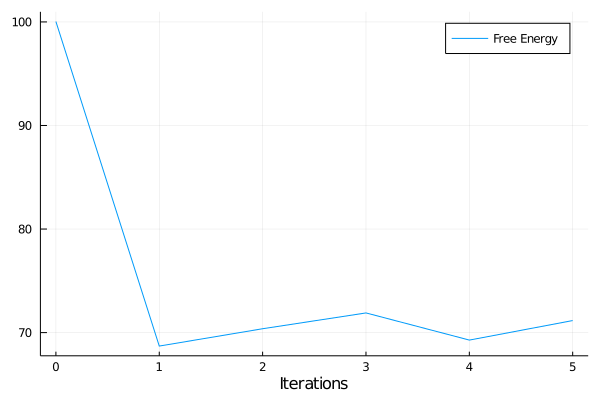

In [72]:
plot(collect(0:1:n_its),FE, label="Free Energy")
xlabel!("Iterations")

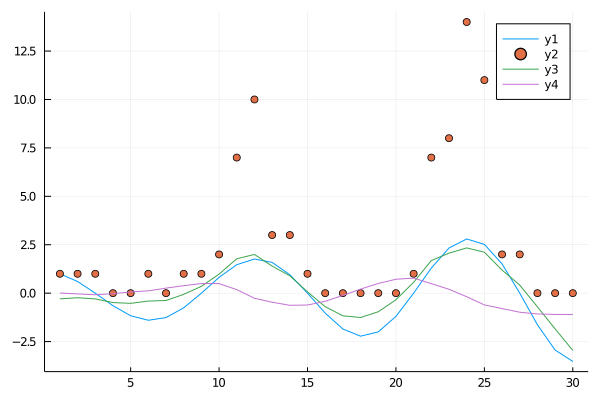

In [74]:
state1_est = zeros(T)
state2_est = zeros(T)

for t=1:T
    state1_est[t] = mean(smooth_estimates[t])[1]
    state2_est[t] = mean(smooth_estimates[t])[2]
end

plot(states[1,:])
scatter!(observation)
plot!(state1_est)
plot!(state2_est)